# SOLAQUA Data Export Demo

This notebook demonstrates how to use `solaqua_utils` for **data bag** exports and reporting.

In [1]:
# If your package is in the same repo, ensure Python can find it (edit the path if needed)
import sys, os
from pathlib import Path
sys.set_int_max_str_digits(100000)

# Add project root to sys.path if running from a subfolder (edit as needed)
project_root = Path.cwd()  # change to your repo root if necessary
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Python version:", sys.version)
print("Working directory:", Path.cwd())


Python version: 3.13.5 (main, Jun 11 2025, 15:36:57) [Clang 17.0.0 (clang-1700.0.13.3)]
Working directory: /Users/eirikvarnes/code/SOLAQUA


In [2]:
# Core utilities for data export and reporting
from utils.data_export import (
    list_topics_in_bag, bag_topic_to_dataframe, save_all_topics_from_data_bags
)
from utils.reporting import (
    load_data_index, list_exported_bag_stems, overview_by_bag, overview_by_datetime,
    topics_in_bag_df, topics_overview_dir
)
from utils.core import find_data_bags
from pathlib import Path
import pandas as pd


## Configure paths

In [3]:
# Point this to your dataset folder containing *_data.bag files
DATA_DIR = Path("data")  # <-- change to your folder
EXPORTS_DIR = Path("exports")
EXPORTS_DIR.mkdir(parents=True, exist_ok=True)

print("Data dir:", DATA_DIR.resolve())
print("Exports dir:", EXPORTS_DIR.resolve())

# Quick peek: list available *_data.bag files
bags = find_data_bags(DATA_DIR, recursive=True)
bags[:5]


Data dir: /Users/eirikvarnes/code/SOLAQUA/data
Exports dir: /Users/eirikvarnes/code/SOLAQUA/exports


[PosixPath('data/2024-08-20_13-39-34_data.bag'),
 PosixPath('data/2024-08-20_13-40-35_data.bag'),
 PosixPath('data/2024-08-22_14-06-43_data.bag'),
 PosixPath('data/2024-08-22_14-29-05_data.bag'),
 PosixPath('data/2024-08-22_14-47-39_data.bag')]

## Inspect topics in a bag

In [4]:
if bags:
    bagpath = bags[0]
    print("Inspecting:", bagpath.name)
    list_topics_in_bag(bagpath)
else:
    print("No *_data.bag files found under", DATA_DIR)


Inspecting: 2024-08-20_13-39-34_data.bag


## Export all topics to CSV/Parquet

## Create Cone NPZ Files from Exported Sonar Data

After exporting sonar data to CSV/Parquet, you can create cone-format NPZ files for analysis.

In [5]:
# Create cone NPZ files from exported sonar data
create_cone_npz = True  # Set to True to create cone NPZ files

if create_cone_npz:
    # Get exported bag stems
    try:
        stems = list_exported_bag_stems(EXPORTS_DIR, bag_suffix="_data")
        if not stems:
            print("⚠️  No exported bag stems found. Run the data export step first.")
        else:
            print(f"📋 Found {len(stems)} exported bag stems")
    except Exception as e:
        print(f"❌ Error getting bag stems: {e}")
        print("   Make sure you've run the data export step first.")
        stems = []

if create_cone_npz and stems:
    print("🔧 Creating cone NPZ files from sonar data...")
    
    # Check if we have CSV files, if not, export from bags first
    csv_found = False
    for bag_stem in stems[:1]:  # Check first bag
        csv_pattern = f"{bag_stem}*sonar*.csv"
        csv_files = list((EXPORTS_DIR / "data").glob(csv_pattern))
        if csv_files:
            csv_found = True
            break
    
    if not csv_found:
        print("📁 No CSV files found. Running data export from bags first...")
        try:
            # Run the export step automatically
            export_index_df = save_all_topics_from_data_bags(
                DATA_DIR, out_dir=EXPORTS_DIR, file_format='csv', recursive=True
            )
            print(f"✅ Exported data from {len(export_index_df)} bag files")
        except Exception as e:
            print(f"❌ Error exporting from bags: {e}")
            print("   Please run the 'Export all topics to CSV/Parquet' cell first (cell 8)")
    
    try:
        # Import sonar processing utilities
        import utils.sonar_utils as sonar_utils
        
        # Cone generation parameters (adjust these for your setup)
        cone_params = {
            "fov_deg": 120.0,           # Field of view in degrees
            "rmin": 0.0,                # Minimum range in meters
            "rmax": 20.0,               # Maximum range in meters 
            "y_zoom": 10.0,             # Display range limit
            "grid": sonar_utils.ConeGridSpec(img_w=900, img_h=700),  # Image size
            "flip_range": False,         # Flip range dimension
            "flip_beams": True,         # Flip beam dimension
            "enhanced": True,           # Apply enhancement
            "enhance_kwargs": {
                "scale": "db",
                "tvg": "amplitude", 
                "p_low": 1.0,
                "p_high": 99.5,
                "gamma": 0.9
            }
        }
        
        # Create NPZ output directory
        npz_output_dir = EXPORTS_DIR / "outputs"
        npz_output_dir.mkdir(parents=True, exist_ok=True)
        
        # Process each exported bag stem
        successful_npz = []
        failed_npz = []
        
        for bag_stem in stems[:5]:  # Limit to first 5 for demo, remove [:5] to process all
            print(f"\n📊 Processing bag: {bag_stem}")
            
            # Look for sonar CSV files for this bag in multiple locations
            search_locations = [
                EXPORTS_DIR / "data",
                EXPORTS_DIR / "by_bag", 
                EXPORTS_DIR
            ]
            
            csv_files = []
            
            for search_dir in search_locations:
                if not search_dir.exists():
                    continue
                    
                # Try multiple patterns to find sonar data
                patterns = [
                    f"{bag_stem}*sonar*.csv",
                    f"{bag_stem}*ping*.csv", 
                    f"{bag_stem}*mbes*.csv",
                    f"*sonoptix*{bag_stem.replace('_data', '_video')}*.csv",  # Handle _video files
                    f"*sonoptix*{bag_stem.replace('_data', '')}*.csv",  # Handle base timestamp
                    f"sensor_sonoptix*{bag_stem.replace('_data', '_video')}*.csv",  # Your exact pattern
                    f"sensor_sonoptix*{bag_stem.replace('_data', '')}*.csv",  # Base timestamp variant
                    f"{bag_stem}*.csv"  # Fallback to any CSV for this bag
                ]
                
                for pattern in patterns:
                    found_files = list(search_dir.glob(pattern))
                    if found_files:
                        csv_files = found_files
                        print(f"   Found files with pattern '{pattern}' in {search_dir.name}/")
                        break
                
                if csv_files:
                    break
            
            if csv_files:
                # Use the first matching CSV file
                csv_path = csv_files[0]
                print(f"   Using CSV: {csv_path.name}")
                
                try:
                    # Load sonar data
                    sonar_df = sonar_utils.load_df(csv_path)
                    print(f"   Loaded {len(sonar_df)} sonar frames")
                    
                    # Create NPZ output path
                    npz_path = npz_output_dir / f"{bag_stem}_cones.npz"
                    
                    # Generate cone data
                    print(f"   Generating cone images...")
                    result = sonar_utils.save_cone_run_npz(
                        sonar_df,
                        npz_path,
                        **cone_params,
                        progress=True
                    )
                    
                    print(f"   ✅ Success! NPZ saved to: {npz_path.name}")
                    print(f"      Frames: {result['num_frames']}")
                    print(f"      Shape: {result['shape']}")
                    print(f"      Extent: {result['extent']}")
                    
                    successful_npz.append({
                        'bag_stem': bag_stem,
                        'npz_path': npz_path,
                        'frames': result['num_frames'],
                        'shape': result['shape']
                    })
                    
                except Exception as e:
                    print(f"   ❌ Error processing {bag_stem}: {e}")
                    failed_npz.append({'bag_stem': bag_stem, 'error': str(e)})
                    
            else:
                print(f"   ⚠️  No sonar CSV files found for {bag_stem}")
                failed_npz.append({'bag_stem': bag_stem, 'error': 'No sonar CSV found'})
        
        # Summary report
        print(f"\n📋 NPZ Creation Summary:")
        print(f"   Successfully created: {len(successful_npz)} NPZ files")
        print(f"   Failed: {len(failed_npz)} bags")
        
        if successful_npz:
            print(f"\n✅ Created NPZ files:")
            for item in successful_npz:
                print(f"   - {item['npz_path'].name}: {item['frames']} frames, shape {item['shape']}")
                
        if failed_npz:
            print(f"\n❌ Failed to process:")
            for item in failed_npz:
                print(f"   - {item['bag_stem']}: {item['error']}")
                
        # Create index of NPZ files
        if successful_npz:
            npz_index = pd.DataFrame(successful_npz)
            npz_index_path = npz_output_dir / "npz_index.csv"
            npz_index.to_csv(npz_index_path, index=False)
            print(f"\n📄 NPZ index saved to: {npz_index_path}")
            
    except ImportError as e:
        print(f"❌ Missing sonar_utils module: {e}")
        print("   Make sure sonar processing utilities are available")
        
    except Exception as e:
        print(f"❌ Error in NPZ creation: {e}")
        
elif create_cone_npz:
    print("⚠️  No exported bag stems available. Run the data export step first.")
    
else:
    print("ℹ️  Set 'create_cone_npz = True' above to create cone NPZ files")
    print("   This will:")
    print("   - Process exported sonar CSV files")
    print("   - Generate cone-format images for each bag")
    print("   - Save NPZ files in exports/outputs/")
    print("   - Create an index of generated files")

📋 Found 5 exported bag stems
🔧 Creating cone NPZ files from sonar data...
📁 No CSV files found. Running data export from bags first...
Wrote exports/by_bag/bluerov2_alive__2024-08-20_13-39-34_data.csv (90 rows).
Wrote exports/by_bag/bluerov2_armed__2024-08-20_13-39-34_data.csv (90 rows).
Wrote exports/by_bag/bluerov2_battery__2024-08-20_13-39-34_data.csv (39 rows).
Wrote exports/by_bag/bluerov2_armed__2024-08-20_13-39-34_data.csv (90 rows).
Wrote exports/by_bag/bluerov2_battery__2024-08-20_13-39-34_data.csv (39 rows).
Wrote exports/by_bag/bluerov2_modes__2024-08-20_13-39-34_data.csv (1 rows).
Wrote exports/by_bag/commanded_thrust__2024-08-20_13-39-34_data.csv (859 rows).
Wrote exports/by_bag/controller_x__2024-08-20_13-39-34_data.csv (296 rows).
Wrote exports/by_bag/bluerov2_modes__2024-08-20_13-39-34_data.csv (1 rows).
Wrote exports/by_bag/commanded_thrust__2024-08-20_13-39-34_data.csv (859 rows).
Wrote exports/by_bag/controller_x__2024-08-20_13-39-34_data.csv (296 rows).
Wrote export

/Users/eirikvarnes/code/SOLAQUA/utils/sonar_utils.py:761: UserWarning: no explicit representation of timezones available for np.datetime64
  ts=np.asarray(ts, dtype="datetime64[ns]"),   # <--- add this


[save_cone_run_npz] wrote exports/outputs/2024-08-20_13-39-34_data_cones.npz (cones=699x700x900)
   ✅ Success! NPZ saved to: 2024-08-20_13-39-34_data_cones.npz
      Frames: 699
      Shape: (699, 700, 900)
      Extent: (-8.660254037844386, 8.660254037844386, 0.0, 10.0)

📊 Processing bag: 2024-08-20_13-40-35_data
   Found files with pattern '*sonoptix*2024-08-20_13-40-35_video*.csv' in by_bag/
   Using CSV: sensor_sonoptix_echo_image__2024-08-20_13-40-35_video.csv
   Loaded 739 sonar frames
   Generating cone images...
  accumulated 0 cone frames ...
   Loaded 739 sonar frames
   Generating cone images...
  accumulated 0 cone frames ...
  accumulated 200 cone frames ...
  accumulated 200 cone frames ...
  accumulated 400 cone frames ...
  accumulated 400 cone frames ...
  accumulated 600 cone frames ...
  accumulated 600 cone frames ...


/Users/eirikvarnes/code/SOLAQUA/utils/sonar_utils.py:761: UserWarning: no explicit representation of timezones available for np.datetime64
  ts=np.asarray(ts, dtype="datetime64[ns]"),   # <--- add this


[save_cone_run_npz] wrote exports/outputs/2024-08-20_13-40-35_data_cones.npz (cones=739x700x900)
   ✅ Success! NPZ saved to: 2024-08-20_13-40-35_data_cones.npz
      Frames: 739
      Shape: (739, 700, 900)
      Extent: (-8.660254037844386, 8.660254037844386, 0.0, 10.0)

📊 Processing bag: 2024-08-22_14-06-43_data
   Found files with pattern '*sonoptix*2024-08-22_14-06-43_video*.csv' in by_bag/
   Using CSV: sensor_sonoptix_echo_image__2024-08-22_14-06-43_video.csv
   Loaded 592 sonar frames
   Generating cone images...
  accumulated 0 cone frames ...
   Loaded 592 sonar frames
   Generating cone images...
  accumulated 0 cone frames ...
  accumulated 200 cone frames ...
  accumulated 200 cone frames ...
  accumulated 400 cone frames ...
  accumulated 400 cone frames ...


/Users/eirikvarnes/code/SOLAQUA/utils/sonar_utils.py:761: UserWarning: no explicit representation of timezones available for np.datetime64
  ts=np.asarray(ts, dtype="datetime64[ns]"),   # <--- add this


[save_cone_run_npz] wrote exports/outputs/2024-08-22_14-06-43_data_cones.npz (cones=592x700x900)
   ✅ Success! NPZ saved to: 2024-08-22_14-06-43_data_cones.npz
      Frames: 592
      Shape: (592, 700, 900)
      Extent: (-8.660254037844386, 8.660254037844386, 0.0, 10.0)

📊 Processing bag: 2024-08-22_14-29-05_data
   Found files with pattern '*sonoptix*2024-08-22_14-29-05_video*.csv' in by_bag/
   Using CSV: sensor_sonoptix_echo_image__2024-08-22_14-29-05_video.csv
   Loaded 995 sonar frames
   Generating cone images...
  accumulated 0 cone frames ...
   Loaded 995 sonar frames
   Generating cone images...
  accumulated 0 cone frames ...
  accumulated 200 cone frames ...
  accumulated 200 cone frames ...
  accumulated 400 cone frames ...
  accumulated 400 cone frames ...
  accumulated 600 cone frames ...
  accumulated 600 cone frames ...
  accumulated 800 cone frames ...
  accumulated 800 cone frames ...


/Users/eirikvarnes/code/SOLAQUA/utils/sonar_utils.py:761: UserWarning: no explicit representation of timezones available for np.datetime64
  ts=np.asarray(ts, dtype="datetime64[ns]"),   # <--- add this


[save_cone_run_npz] wrote exports/outputs/2024-08-22_14-29-05_data_cones.npz (cones=995x700x900)
   ✅ Success! NPZ saved to: 2024-08-22_14-29-05_data_cones.npz
      Frames: 995
      Shape: (995, 700, 900)
      Extent: (-8.660254037844386, 8.660254037844386, 0.0, 10.0)

📊 Processing bag: 2024-08-22_14-47-39_data
   Found files with pattern '*sonoptix*2024-08-22_14-47-39_video*.csv' in by_bag/
   Using CSV: sensor_sonoptix_echo_image__2024-08-22_14-47-39_video.csv
   Loaded 726 sonar frames
   Generating cone images...
  accumulated 0 cone frames ...
   Loaded 726 sonar frames
   Generating cone images...
  accumulated 0 cone frames ...
  accumulated 200 cone frames ...
  accumulated 200 cone frames ...
  accumulated 400 cone frames ...
  accumulated 400 cone frames ...
  accumulated 600 cone frames ...
  accumulated 600 cone frames ...


/Users/eirikvarnes/code/SOLAQUA/utils/sonar_utils.py:761: UserWarning: no explicit representation of timezones available for np.datetime64
  ts=np.asarray(ts, dtype="datetime64[ns]"),   # <--- add this


[save_cone_run_npz] wrote exports/outputs/2024-08-22_14-47-39_data_cones.npz (cones=726x700x900)
   ✅ Success! NPZ saved to: 2024-08-22_14-47-39_data_cones.npz
      Frames: 726
      Shape: (726, 700, 900)
      Extent: (-8.660254037844386, 8.660254037844386, 0.0, 10.0)

📋 NPZ Creation Summary:
   Successfully created: 5 NPZ files
   Failed: 0 bags

✅ Created NPZ files:
   - 2024-08-20_13-39-34_data_cones.npz: 699 frames, shape (699, 700, 900)
   - 2024-08-20_13-40-35_data_cones.npz: 739 frames, shape (739, 700, 900)
   - 2024-08-22_14-06-43_data_cones.npz: 592 frames, shape (592, 700, 900)
   - 2024-08-22_14-29-05_data_cones.npz: 995 frames, shape (995, 700, 900)
   - 2024-08-22_14-47-39_data_cones.npz: 726 frames, shape (726, 700, 900)

📄 NPZ index saved to: exports/outputs/npz_index.csv


🔍 Loading and verifying created NPZ files...

📂 Loading NPZ file: 2024-08-20_13-39-34_data_cones.npz
✅ Successfully loaded NPZ file:
   Shape: (699, 700, 900)
   Time range: 2024-08-20 11:40:23.268609+00:00 to 2024-08-20 11:40:23.268609+00:00
   Spatial extent: (-8.66025447845459, 8.66025447845459, 0.0, 10.0)
   Metadata keys: ['format', 'fov_deg', 'rmin', 'rmax', 'y_zoom', 'grid', 'flips', 'enhanced', 'enhance_kwargs']
✅ Successfully loaded NPZ file:
   Shape: (699, 700, 900)
   Time range: 2024-08-20 11:40:23.268609+00:00 to 2024-08-20 11:40:23.268609+00:00
   Spatial extent: (-8.66025447845459, 8.66025447845459, 0.0, 10.0)
   Metadata keys: ['format', 'fov_deg', 'rmin', 'rmax', 'y_zoom', 'grid', 'flips', 'enhanced', 'enhance_kwargs']


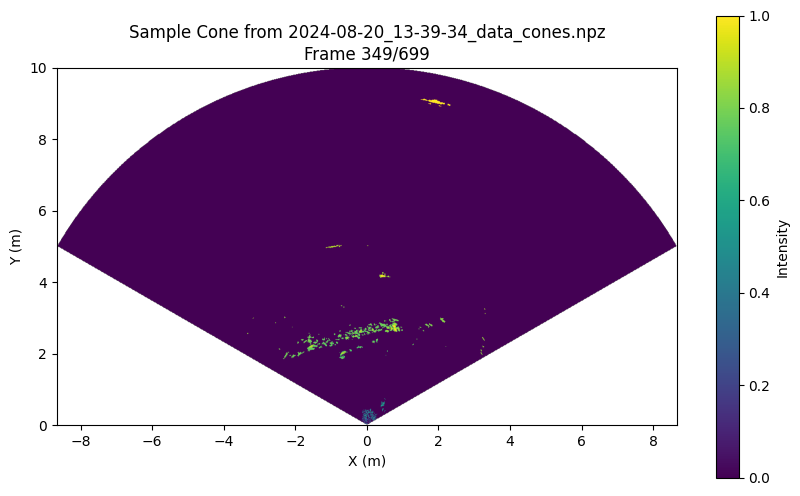


📊 Data Quality Check:
   Valid data ratio: 0.603
   Intensity range: [0.000, 1.000]
   Valid data ratio: 0.603
   Intensity range: [0.000, 1.000]
   Mean intensity: 0.005

✅ NPZ file is ready for analysis!
   Use this path in analysis notebooks: 'exports/outputs/2024-08-20_13-39-34_data_cones.npz'
   Mean intensity: 0.005

✅ NPZ file is ready for analysis!
   Use this path in analysis notebooks: 'exports/outputs/2024-08-20_13-39-34_data_cones.npz'


In [6]:
# Load and verify created NPZ files
if 'successful_npz' in locals() and successful_npz:
    print("🔍 Loading and verifying created NPZ files...")
    
    try:
        import utils.image_analysis_utils as iau
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Pick the first NPZ file to verify
        test_npz = successful_npz[0]
        npz_path = test_npz['npz_path']
        
        print(f"\n📂 Loading NPZ file: {npz_path.name}")
        
        # Load the NPZ file
        cones, timestamps, extent, meta = iau.load_cone_run_npz(str(npz_path))
        
        print(f"✅ Successfully loaded NPZ file:")
        print(f"   Shape: {cones.shape}")
        print(f"   Time range: {timestamps[0]} to {timestamps[-1]}")
        print(f"   Spatial extent: {extent}")
        print(f"   Metadata keys: {list(meta.keys()) if isinstance(meta, dict) else 'Simple metadata'}")
        
        # Visualize a sample frame
        sample_idx = len(cones) // 2
        sample_cone = cones[sample_idx]
        
        plt.figure(figsize=(10, 6))
        plt.imshow(sample_cone, cmap='viridis', origin='lower', extent=extent, aspect='equal')
        plt.title(f'Sample Cone from {npz_path.name}\nFrame {sample_idx}/{len(cones)}')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.colorbar(label='Intensity')
        plt.show()
        
        # Data quality checks
        print(f"\n📊 Data Quality Check:")
        print(f"   Valid data ratio: {(~np.isnan(cones)).mean():.3f}")
        print(f"   Intensity range: [{np.nanmin(cones):.3f}, {np.nanmax(cones):.3f}]")
        print(f"   Mean intensity: {np.nanmean(cones):.3f}")
        
        print(f"\n✅ NPZ file is ready for analysis!")
        print(f"   Use this path in analysis notebooks: '{npz_path}'")
        
    except Exception as e:
        print(f"❌ Error loading NPZ file: {e}")
        
elif 'npz_output_dir' in locals():
    # Check if any NPZ files exist in the output directory
    existing_npz = list(npz_output_dir.glob("*.npz"))
    if existing_npz:
        print(f"📁 Found {len(existing_npz)} existing NPZ files in {npz_output_dir}:")
        for npz_file in existing_npz[:10]:
            print(f"   - {npz_file.name}")
        if len(existing_npz) > 10:
            print(f"   ... and {len(existing_npz) - 10} more")
            
        print(f"\n🔧 To verify an existing NPZ file, try:")
        print(f"   import utils.image_analysis_utils as iau")
        print(f"   cones, ts, extent, meta = iau.load_cone_run_npz('{existing_npz[0]}')")
    else:
        print("ℹ️  No NPZ files found. Run the cone creation step above first.")
        
else:
    print("ℹ️  Create NPZ files first to load and verify them.")

## Load index and list exported bag stems

In [7]:
try:
    idx = load_data_index(EXPORTS_DIR)
    display(idx.head(10))
    stems = list_exported_bag_stems(EXPORTS_DIR, bag_suffix="_data")
    print("Exported bag stems (first 15):", stems[:15])
except FileNotFoundError as e:
    print(e)


,bag,bag_file,topic,msgtypes,rows,out_file
0,2024-08-20_13-39-34_data,2024-08-20_13-39-34_data.bag,/bluerov2/alive,['std_msgs/msg/Float32'],90,exports/by_bag/bluerov2_alive__2024-08-20_13-3...
1,2024-08-20_13-39-34_data,2024-08-20_13-39-34_data.bag,/bluerov2/armed,['std_msgs/msg/Float32'],90,exports/by_bag/bluerov2_armed__2024-08-20_13-3...
2,2024-08-20_13-39-34_data,2024-08-20_13-39-34_data.bag,/bluerov2/battery,['messages/msg/BatteryStatus'],39,exports/by_bag/bluerov2_battery__2024-08-20_13...
3,2024-08-20_13-39-34_data,2024-08-20_13-39-34_data.bag,/bluerov2/modes,['joystick/msg/ModeManager2'],1,exports/by_bag/bluerov2_modes__2024-08-20_13-3...
4,2024-08-20_13-39-34_data,2024-08-20_13-39-34_data.bag,/commanded_thrust,['rospy_tutorials/msg/Floats'],859,exports/by_bag/commanded_thrust__2024-08-20_13...
5,2024-08-20_13-39-34_data,2024-08-20_13-39-34_data.bag,/controller/x,['messages/msg/MRACOupdate'],296,exports/by_bag/controller_x__2024-08-20_13-39-...
6,2024-08-20_13-39-34_data,2024-08-20_13-39-34_data.bag,/controller/y,['messages/msg/MRACOupdate'],300,exports/by_bag/controller_y__2024-08-20_13-39-...
7,2024-08-20_13-39-34_data,2024-08-20_13-39-34_data.bag,/controller/yaw,['messages/msg/PIDState'],301,exports/by_bag/controller_yaw__2024-08-20_13-3...
8,2024-08-20_13-39-34_data,2024-08-20_13-39-34_data.bag,/controller/z,['messages/msg/PIDState'],300,exports/by_bag/controller_z__2024-08-20_13-39-...
9,2024-08-20_13-39-34_data,2024-08-20_13-39-34_data.bag,/gui/netFollowing_manager,['messages/msg/NetFollowingManager'],39,exports/by_bag/gui_netFollowing_manager__2024-...


Exported bag stems (first 15): ['2024-08-20_13-39-34_data', '2024-08-20_13-40-35_data', '2024-08-22_14-06-43_data', '2024-08-22_14-29-05_data', '2024-08-22_14-47-39_data']


## Overview by specific bag

In [8]:
if 'stems' in locals() and stems:
    bag_stem = stems[-1]  # pick one
    files_df, topics_df = overview_by_bag(bag_stem, out_dir=EXPORTS_DIR)
    print("Files summary:")
    display(files_df.head(20))
    print("\nTopic aggregates:")
    display(topics_df.head(50))
else:
    print("No stems available yet. Run the export step above.")


Files summary:


,bag,topic,out_file,rows,t_min,t_max,duration_s,approx_rate_hz
0,2024-08-22_14-47-39_data,/bluerov2/alive,exports/by_bag/bluerov2_alive__2024-08-22_14-4...,88,1.724331e+09,1.724331e+09,43.071555,2.043112
1,2024-08-22_14-47-39_data,/bluerov2/armed,exports/by_bag/bluerov2_armed__2024-08-22_14-4...,88,1.724331e+09,1.724331e+09,43.388417,2.028191
2,2024-08-22_14-47-39_data,/bluerov2/battery,exports/by_bag/bluerov2_battery__2024-08-22_14...,41,1.724331e+09,1.724331e+09,41.751813,0.981993
3,2024-08-22_14-47-39_data,/bluerov2/modes,exports/by_bag/bluerov2_modes__2024-08-22_14-4...,1,1.724331e+09,1.724331e+09,0.000000,NaN
4,2024-08-22_14-47-39_data,/commanded_thrust,exports/by_bag/commanded_thrust__2024-08-22_14...,860,1.724331e+09,1.724331e+09,42.954471,20.021199
5,2024-08-22_14-47-39_data,/controller/x,exports/by_bag/controller_x__2024-08-22_14-47-...,372,1.724331e+09,1.724331e+09,41.268582,9.014121
6,2024-08-22_14-47-39_data,/controller/y,exports/by_bag/controller_y__2024-08-22_14-47-...,377,1.724331e+09,1.724331e+09,41.817128,9.015444
7,2024-08-22_14-47-39_data,/controller/yaw,exports/by_bag/controller_yaw__2024-08-22_14-4...,368,1.724331e+09,1.724331e+09,40.828597,9.013290
8,2024-08-22_14-47-39_data,/controller/z,exports/by_bag/controller_z__2024-08-22_14-47-...,376,1.724331e+09,1.724331e+09,41.699479,9.016899
9,2024-08-22_14-47-39_data,/gui/netFollowing_manager,exports/by_bag/gui_netFollowing_manager__2024-...,42,1.724331e+09,1.724331e+09,41.009797,1.024146



Topic aggregates:


,topic,rows,duration_s,approx_rate_hz
0,/bluerov2/alive,88,43.071555,2.043112
1,/bluerov2/armed,88,43.388417,2.028191
2,/bluerov2/battery,41,41.751813,0.981993
3,/bluerov2/modes,1,0.000000,NaN
4,/commanded_thrust,860,42.954471,20.021199
5,/controller/x,372,41.268582,9.014121
6,/controller/y,377,41.817128,9.015444
7,/controller/yaw,368,40.828597,9.013290
8,/controller/z,376,41.699479,9.016899
9,/gui/netFollowing_manager,42,41.009797,1.024146


## Overview by date & time helper

In [9]:
# If your bag naming follows 'YYYY-MM-DD_HH-MM-SS_data', you can use:
# date_str = '2024-08-20'; time_str = '13:55:34'
# bag_stem, files_df, topics_df = overview_by_datetime(date_str, time_str, out_dir=EXPORTS_DIR)
# display(files_df.head()); display(topics_df.head())


## Topic listing for any .bag

In [10]:
# You can run topic listings (with optional counts) on any .bag file:
if bags:
    df_topics = topics_in_bag_df(bags[-1], with_counts=False)
    display(df_topics.head(40))
else:
    print("No bags to list topics from.")


,topic,msgtype
0,/bluerov2/alive,std_msgs/msg/Float32
1,/bluerov2/armed,std_msgs/msg/Float32
2,/bluerov2/battery,messages/msg/BatteryStatus
3,/bluerov2/modes,joystick/msg/ModeManager2
4,/commanded_thrust,rospy_tutorials/msg/Floats
5,/controller/x,messages/msg/MRACOupdate
6,/controller/y,messages/msg/MRACOupdate
7,/controller/yaw,messages/msg/PIDState
8,/controller/z,messages/msg/PIDState
9,/gui/netFollowing_manager,messages/msg/NetFollowingManager


## Directory-wide topic overview

In [11]:
# Scan a directory for .bag files and list topics. Set suffix_filter to narrow to '_data' or '_video'.
df_dir = topics_overview_dir(DATA_DIR, recursive=True, suffix_filter="_data", with_counts=False)
display(df_dir.head(30))


,bag_file,bag_stem,topic,msgtype
0,2024-08-20_13-39-34_data.bag,2024-08-20_13-39-34_data,/bluerov2/alive,std_msgs/msg/Float32
1,2024-08-20_13-39-34_data.bag,2024-08-20_13-39-34_data,/bluerov2/armed,std_msgs/msg/Float32
2,2024-08-20_13-39-34_data.bag,2024-08-20_13-39-34_data,/bluerov2/battery,messages/msg/BatteryStatus
3,2024-08-20_13-39-34_data.bag,2024-08-20_13-39-34_data,/bluerov2/modes,joystick/msg/ModeManager2
4,2024-08-20_13-39-34_data.bag,2024-08-20_13-39-34_data,/commanded_thrust,rospy_tutorials/msg/Floats
5,2024-08-20_13-39-34_data.bag,2024-08-20_13-39-34_data,/controller/x,messages/msg/MRACOupdate
6,2024-08-20_13-39-34_data.bag,2024-08-20_13-39-34_data,/controller/y,messages/msg/MRACOupdate
7,2024-08-20_13-39-34_data.bag,2024-08-20_13-39-34_data,/controller/yaw,messages/msg/PIDState
8,2024-08-20_13-39-34_data.bag,2024-08-20_13-39-34_data,/controller/z,messages/msg/PIDState
9,2024-08-20_13-39-34_data.bag,2024-08-20_13-39-34_data,/gui/netFollowing_manager,messages/msg/NetFollowingManager


In [12]:
from utils.reporting import topics_overview_dir
df = topics_overview_dir("exports/by_bag", recursive=True, suffix_filter=None, with_counts=False)
df[df["topic"].str.contains("sonar|sonoptix|ping360|ping\\b|mbes", case=False, regex=True)].head(30)


,bag_file,bag_stem,topic,msgtype
